In [ ]:
#### Create Plots based on OSCAR xml files ####
# analysis of specific variables

# used python version 3.10.6

In [1]:
import xml.etree.ElementTree as ET
import urllib.request
import csv
import requests
from bs4 import BeautifulSoup
from urllib.request import urlopen
import json
import re
import os
import pandas as pd

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import pandas as pd
import matplotlib.lines as mlines
from urllib.request import urlopen
from functools import reduce


In [2]:
country = "KEN"
variable = "224"

In [44]:
# API: all stations in country
all_stations_KEN_url = "https://oscar.wmo.int/surface/rest/api/search/station?territoryName="+country

response = urlopen(all_stations_KEN_url)
data_json = json.loads(response.read())
stations = data_json["stationSearchResults"]

wigosIds = []

for station in data_json["stationSearchResults"]:
    # print(station["wigosId"])
    wigosId = str(station["wigosId"])
    wigosIds.append(wigosId)

print(wigosIds)

['0-404-300-301570787AS00074', '0-404-300-402261127AS63663', '0-404-300-271440721AS00049', '0-404-300-281480740AS00057', '0-404-300-160800395AS00001', '0-404-0-63707', '0-404-300-392191090AS63662', '0-404-0-63721', '0-404-300-040200100AS00113', '0-404-300-040200098AS00112', '0-404-300-301620807AS00073', '0-404-300-301580790AS00071', '0-404-300-402251125AS00038', '0-404-300-402281141AS00036', '0-404-300-402291146AS00033', '0-404-300-392181085AS63660', '0-404-300-361950974AS00015', '0-20000-0-63741', '0-404-300-472781389AS63747', '0-404-300-100470235AS00114', '0-404-300-372081037AS00024', '0-404-300-372000999AS00025', '0-404-300-372031019AS00022', '0-404-300-372101048AS00026', '0-20000-0-63688', '0-404-300-63686', '0-20000-0-63720', '0-404-0-63719', '0-404-300-341870932AS00005', '0-404-300-341840918A00001', '0-404-300-050210101AS00090', '0-404-0-63670', '0-20000-0-63723', '0-404-300-190950473AS00101', '0-404-300-060230111AS00047', '0-404-300-190950476AS00099', '0-404-300-070320150AS00107

In [45]:
def get_info(id):

    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')

    # Retrieve all of the anchor tags
    content = soup('OAI-PMH')

    return(content)

In [25]:
# prepare data frame #
df_variable = pd.DataFrame(np.nan, index=[0],columns=["beginPosition", "endPosition", "station", "variable"])


for id in wigosIds:
    # station_info = get_info(id)
    # print(station_info)
    observedProperties = []
    url = "https://oscar.wmo.int/oai/provider?verb=GetRecord&metadataPrefix=wmdr&identifier=%20" + id
    xml = urlopen(url).read()
    soup = BeautifulSoup(xml, 'xml')

    # with open(os.getcwd()+"/Files/File_"+id+".txt", 'w') as f:
    #     f.write(str(get_info(id)))

    with open(os.getcwd()+"/Files/File_"+id+".txt") as myFile:
        observedProperties_line = soup.find_all('observedProperty')
        observedProperties_notation = re.findall(r'\d+',str(observedProperties_line))
        observedProperties.append(observedProperties_notation)
    
    
    if str(variable) in observedProperties[0]:
        station = id

        # find line numbers containing the WMDR number of the observed property
        numbers = []

        with open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt') as myFile:
            for num, line in enumerate(myFile, 1):
                if variable in line:
                    numbers.append(num)

        # find the line numbers with <om:observedProperty
        obs = "observedProperty"
        numbers_obs = []

        f=open(os.getcwd()+"/Files/File_"+id+".txt")
        lines=f.readlines()

        for n in numbers:
            # print("test: ", n)
            if obs in lines[n-1]:
                # print(n)
                number = re.findall(r'\d+',lines[n-1])
                if number[0]==str(variable):
                    numbers_obs.append(n)

        ### read 20 lines before "observedProperty" line to get "beginPosition" (& "endPosition")
        for n in numbers_obs:
            start = "beginPosition"
            end = "endPosition"
            line_numbers = range(n-50,n)

            f=open('/home/sdanioth/Documents/git/OSCAR_analysis/Files/File_'+id+'.txt')
            lines=f.readlines()
            positions = []

            for n in line_numbers:
                # print("n: ", n)
                if start in lines[n]:
                    beginning = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                    if beginning:
                        pd.to_datetime(beginning, format='%Y-%m-%d')
                        positions.append(beginning[0])
                    else:
                        positions.append(np.nan)

                elif end in lines[n]:
                    ending = re.findall(r'\d{4}-\d{2}-\d{2}',lines[n])
                    if ending:
                        pd.to_datetime(ending, format='%Y-%m-%d')
                        positions.append(ending[0])
                    else:
                        positions.append(pd.Timestamp.today().strftime("%Y-%m-%d"))

            beginPosition  = positions[0]
            endPosition = positions[1]
            new_row = {"beginPosition":beginPosition,"endPosition":endPosition,"station":station,"variable":variable}
            df_variable.loc[len(df_variable)] = new_row
        
    else: 
        station = id
        new_row = {"beginPosition":np.nan,"endPosition":np.nan,"station":station,"variable":variable}
        df_variable.loc[len(df_variable)] = new_row


df_variable.drop([0], axis=0, inplace=True)


df_variable



,beginPosition,endPosition,station,variable
1,2021-11-29,2023-11-20,0-404-300-301570787AS00074,224
2,2020-12-15,2023-11-20,0-404-300-402261127AS63663,224
3,2021-11-18,2023-11-20,0-404-300-271440721AS00049,224
4,2021-11-29,2023-11-20,0-404-300-281480740AS00057,224
5,2022-09-25,2023-11-20,0-404-300-160800395AS00001,224
...,...,...,...,...
162,NaN,NaN,0-22000-0-1901045,224
163,NaN,NaN,0-22000-0-1901046,224
164,NaN,NaN,0-22000-0-1901047,224
165,NaN,NaN,0-22000-0-1901048,224


In [36]:
# combine 3 dictionaries (Atmosphere, Ocean & Terrestrial)

with open(os.getcwd()+'/WMDR_dictionaries/'+'T_GO_VARIABLE_REF_dictionary.json') as f:
    dictionary = json.loads(f.read())


variables = df_variable["variable"]

df_variable["variables_names"] = [(list(dictionary.keys())[list(dictionary.values()).index(str(vari))]) for vari in variables]



  beginPosition endPosition                     station variable  \
1    2021-11-29  2023-11-20  0-404-300-301570787AS00074      224   

                                     variables_names  
1  Air temperature (at specified distance from re...  
  beginPosition endPosition                     station variable  \
2    2020-12-15  2023-11-20  0-404-300-402261127AS63663      224   

                                     variables_names  
2  Air temperature (at specified distance from re...  
  beginPosition endPosition                     station variable  \
3    2021-11-18  2023-11-20  0-404-300-271440721AS00049      224   

                                     variables_names  
3  Air temperature (at specified distance from re...  
  beginPosition endPosition                     station variable  \
4    2021-11-29  2023-11-20  0-404-300-281480740AS00057      224   

                                     variables_names  
4  Air temperature (at specified distance from re...  
  beginPosit

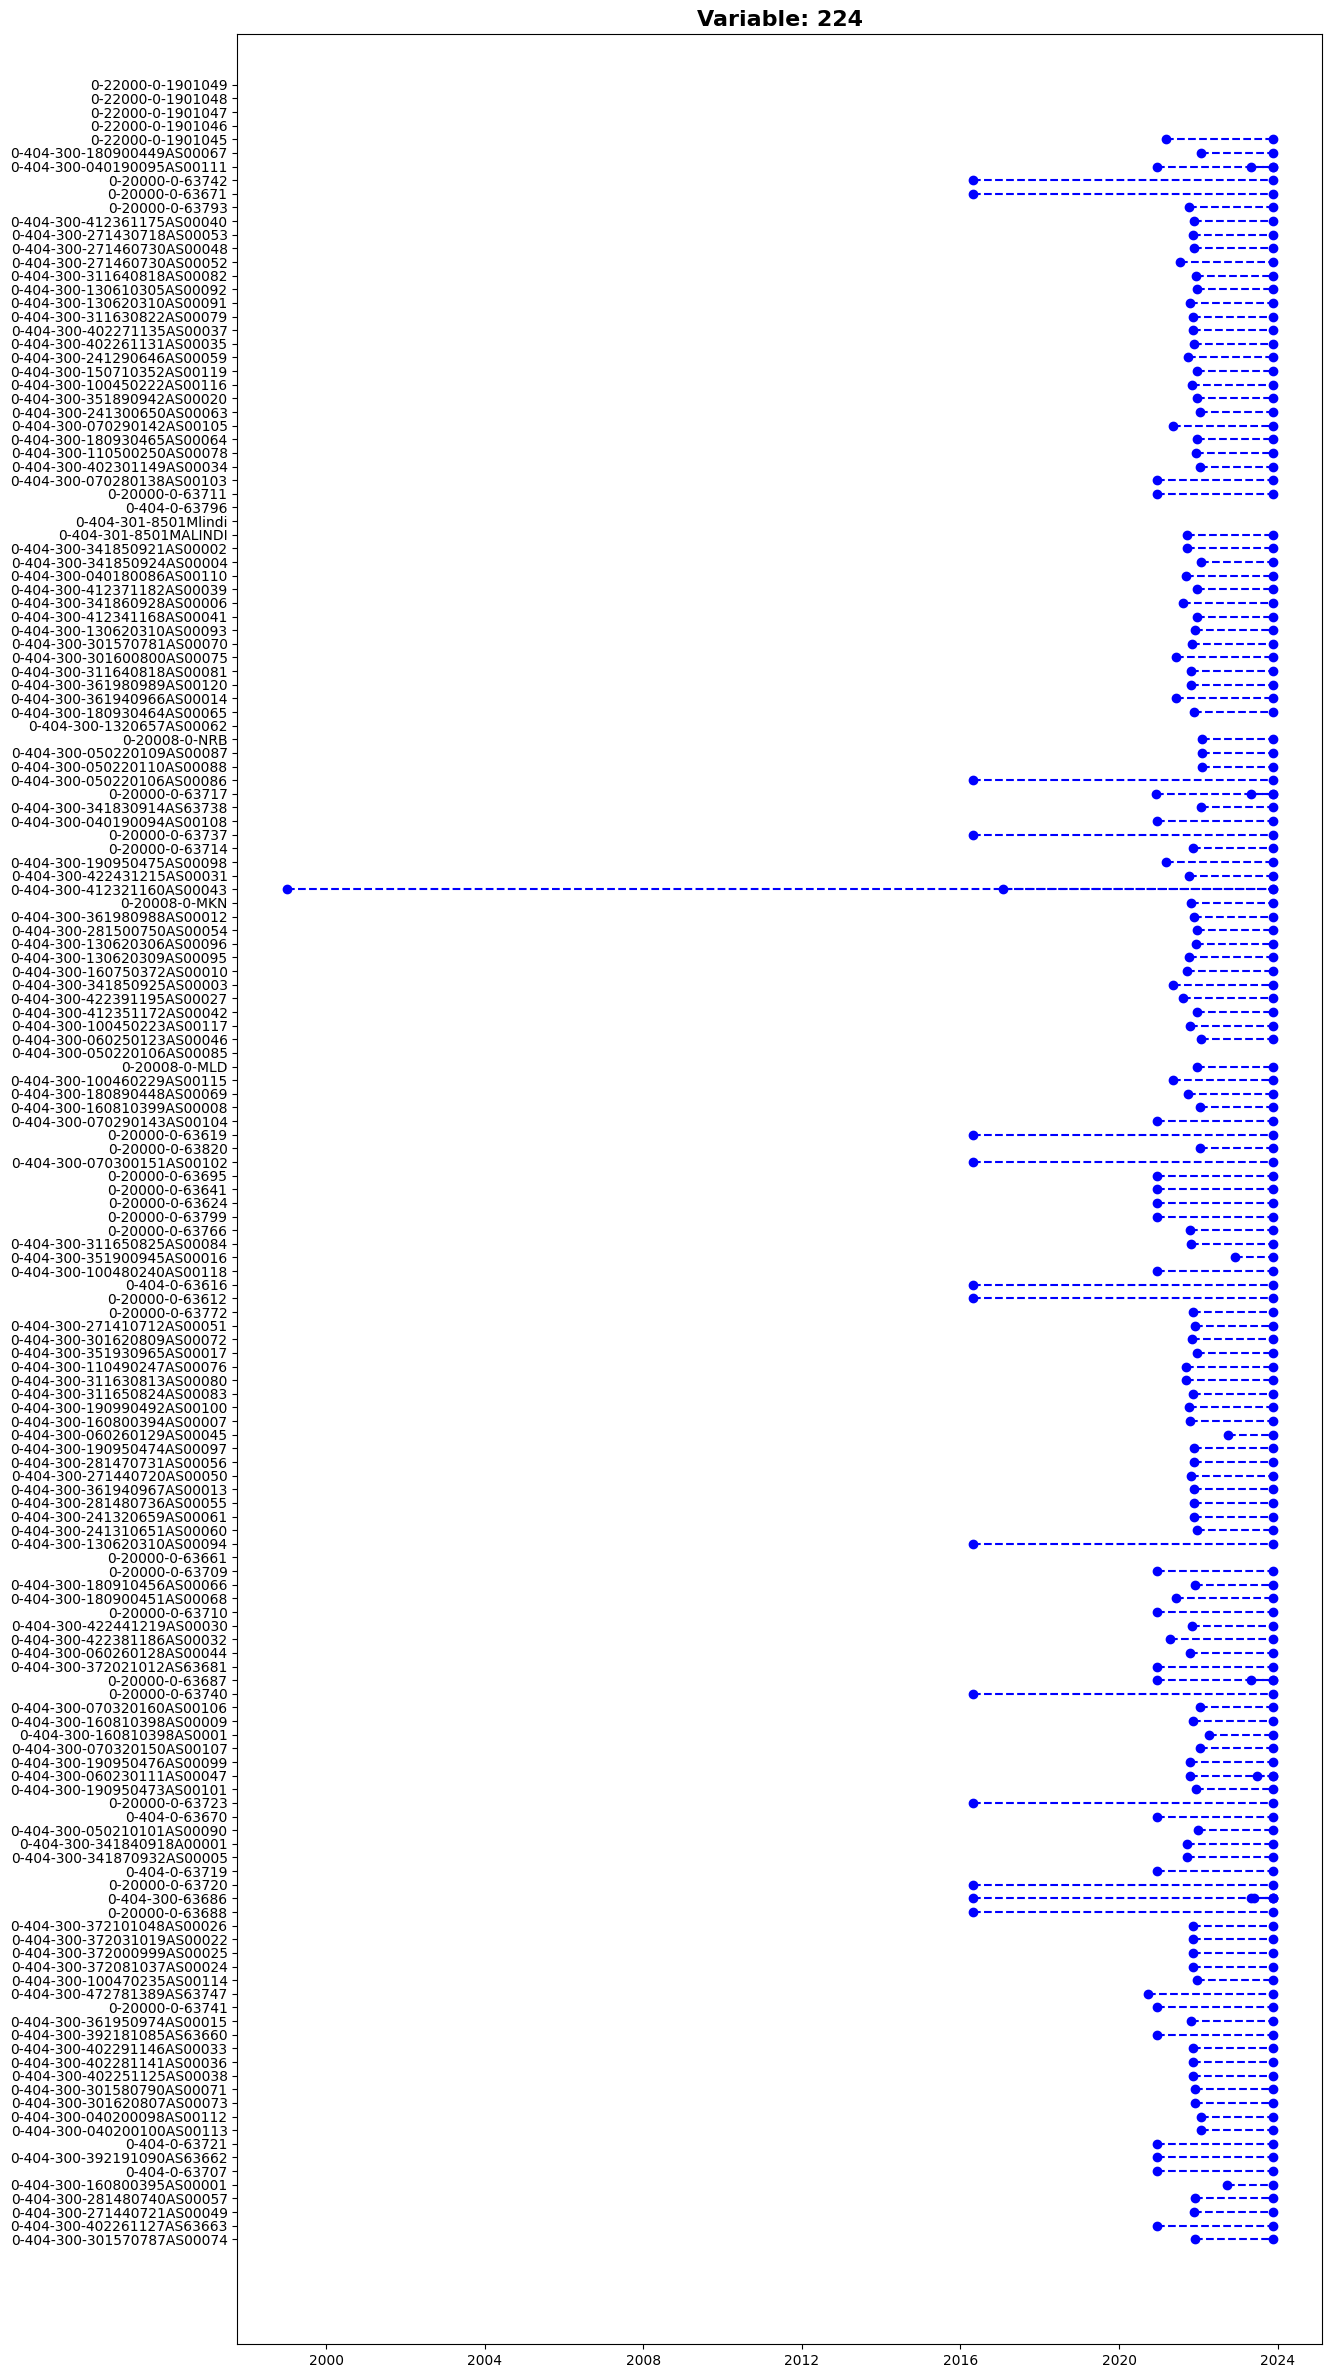

In [43]:
plt.style.use('default')
fig, axes = plt.subplots(1,1, figsize=(14,30))

# variables = variables_u

for id in range(0,len(wigosIds)):
    df_var = df_variable[df_variable["station"]==str(wigosIds[id])]

    x_values = [pd.to_datetime(df_var["beginPosition"]), pd.to_datetime(df_var["endPosition"])]
    plt.plot(x_values, [id,id], 'bo', linestyle="--")

names = []
for var in range(0,len(wigosIds)):
    variable_df = df_variable[df_variable["station"]==str(wigosIds[var])]
    # print(variable_df)
    if not variable_df.empty:
        name = str(variable_df.iloc[0]["station"])
        names.append(name)

n = range(0,len(names))
plt.yticks(n,names)

# title
plt.title("Variable: " + variable, fontsize=16, fontweight="bold")


# save figure
fig.savefig(os.getcwd()+"/Plots/Variable_"+variable+"_"+country+".jpeg", bbox_inches='tight')